<a href="https://colab.research.google.com/github/Francimaria/Sistemas_de_Multiplos_Classificadores/blob/main/exercicio1_q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install  deslib

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Perceptron
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier,BaseEnsemble
from sklearn.linear_model import SGDClassifier
from scipy import stats

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from deslib.static import Oracle
import rlo #RLO from https://github.com/filipeclduarte/ensemble_learning/blob/main/rlo.py

### **Questão 1**

Selecione cinco bases de dados públicas que contenham características diferentes e, para cada base, calcule o Oracle no conjunto de teste para Bagging, Adaboost, Random Subspace (50\%) e Random Oracles, variando o número de classificadores-base ${10, 20, …, 100}$. Use o Perceptron como classificador-base e divida os fold usando o 5-fold cross-validation. Analise os resultados.

**Bases de dados públicas**

df1 - https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set

df2 - https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

df3 - https://archive.ics.uci.edu/ml/datasets/banknote+authentication

df4 - https://archive.ics.uci.edu/ml/datasets/Wine+Quality

df5 - https://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29





In [4]:
file_1_name = "https://raw.githubusercontent.com/Francimaria/Sistemas_de_Multiplos_Classificadores/main/dataset/messidor_features.csv"
file_2_name = "https://raw.githubusercontent.com/Francimaria/Sistemas_de_Multiplos_Classificadores/main/dataset/breast-cancer-wisconsin.csv"
file_3_name = "https://raw.githubusercontent.com/Francimaria/Sistemas_de_Multiplos_Classificadores/main/dataset/data_banknote_authentication.csv"
file_4_name = "https://raw.githubusercontent.com/Francimaria/Sistemas_de_Multiplos_Classificadores/main/dataset/winequality-white.csv"
file_5_name = "https://raw.githubusercontent.com/Francimaria/Sistemas_de_Multiplos_Classificadores/main/dataset/Frogs_MFCCs.csv"

df1 = pd.read_csv(file_1_name, header=None,skiprows=1)
df2 = pd.read_csv(file_2_name, header=None)
df3 = pd.read_csv(file_3_name, header=None)
df4 = pd.read_csv(file_4_name, header=None,skiprows=1, sep=";")
df5 = pd.read_csv(file_5_name, header=None,skiprows=1)

**Pré-processamento**

In [5]:
print("Shape: ", df1.shape)
print(df1[df1.columns[-1]].value_counts())

print("Shape: ", df2.shape)
print("0 for benign, 1 for malignant")
df2[df2.columns[-1]].replace([2, 4], [0, 1], inplace=True)
print(df2[df2.columns[-1]].value_counts())

# Remove ID
df2 = df2.drop([df2.columns[0]], axis=1)

print("Shape: ", df3.shape)
print(df3[df3.columns[-1]].value_counts())

print("Shape: ", df4.shape)
print("Replace classes [3,4,..,9] to [0,1,...6]")
df4[df4.columns[-1]].replace([3,4,5,6,7,8,9], [0,1,2,3,4,5,6], inplace=True)
print(df4[df4.columns[-1]].value_counts())

# Remover ID, gênero, e espécie (apenas families é usado como classe)
df5 = df5.drop([23,24,25], axis=1)

print("Replace classes [Leptodactylidae, Hylidae, Dendrobatidae, Bufonidae] to [0,1,2,3]")
print("Shape: ", df5.shape)
df5[df5.columns[-1]].replace(['Leptodactylidae', 'Hylidae', 'Dendrobatidae', 'Bufonidae'], [0,1,2,3], inplace=True)
print(df5[df5.columns[-1]].value_counts())

Shape:  (1151, 20)
1    611
0    540
Name: 19, dtype: int64
Shape:  (683, 11)
0 for benign, 1 for malignant
0    444
1    239
Name: 10, dtype: int64
Shape:  (1372, 5)
0    762
1    610
Name: 4, dtype: int64
Shape:  (4898, 12)
Replace classes [3,4,..,9] to [0,1,...6]
3    2198
2    1457
4     880
5     175
1     163
0      20
6       5
Name: 11, dtype: int64
Replace classes [Leptodactylidae, Hylidae, Dendrobatidae, Bufonidae] to [0,1,2,3]
Shape:  (7195, 23)
0    4420
1    2165
2     542
3      68
Name: 22, dtype: int64


In [6]:
data = []
classe = []
df = [df1,df2,df3,df4,df5]

# Padronização dos dados na mesma escala
for d in df:
  x = d.drop([d.columns[-1]], axis=1)
  x = np.array(preprocessing.scale(x))  
  y = np.array(d[d.columns[-1]])
  
  data.append(x)
  classe.append(y)

K-fold e inicialização dos parâmetros

In [7]:
#random_state: Using an int will produce the same results across different calls. 
kf = StratifiedKFold(n_splits=5, random_state=5)

n_estimators = np.arange(10, 110, 10)
print(n_estimators)

base_estimator=Perceptron()
print(base_estimator)


[ 10  20  30  40  50  60  70  80  90 100]
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)


**Executar o pool de classificadores**

In [68]:
def run_ensemble(pool_classifiers, X, y, oracle="deslib"):
  score = []
  oracle_score = []

  for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    pool_classifiers.fit(X_train, y_train)

    if oracle == "RS":
      #oracle Random Subspace 
      y_pred = pool_classifiers.predict(X_test)    
      score.append(accuracy_score(y_test, y_pred))
      oracle_score.append(Oracle_RS(pool_classifiers, X_test, y_test))
      
    elif oracle == "RLO": 
      # Oracle from RLO      
      while True:
        try:
          pool_classifiers.fit(X_train, y_train)
          preds, y_pred,error = pool_classifiers.predict(X_test, y_test)    
          score.append(accuracy_score(y_test, np.array(y_pred.T)))   
          break
        except:
            continue
        break   
      oracle_score.append(pool_classifiers.Oracle_score(X_test, y_test))    

    else: 
      # Oracle from deslib
      y_pred = pool_classifiers.predict(X_test) 
      score.append(accuracy_score(y_test, y_pred))

      oracle = Oracle(pool_classifiers).fit(X_train, y_train)

      oracle_score.append(oracle.score(X_test, y_test))

  return score, oracle_score

**Oracle do RS**

In [ ]:
# From https://github.com/amorimlb/Doc_MCS/blob/main/Exercicio1/ex1.ipynb
def Oracle_RS(clf, X_test, y_test):
    X_test = pd.DataFrame(X_test)
    base_models = clf.estimators_
    base_models_feats = clf.estimators_features_

    base_models_preds = []
    for i in range(len(base_models)):
        #selecting only the columns used for the ith base model.
        X_test_subspace = X_test.iloc[:,base_models_feats[i]] 
        y_pred = base_models[i].predict(X_test_subspace)
        base_models_preds.append(y_pred)

    oracle_hits = []
    for i in range(len(y_test)):
        oracle_hit = 0
        for j in range(len(base_models_preds)):
            if base_models_preds[j][i] == y_test[i]:
                oracle_hit = 1
                break
        oracle_hits.append(oracle_hit)

    oracle_score = np.sum(oracle_hits)/len(oracle_hits)

    return oracle_score

**Bagging**

In [ ]:
# Datafile para salvar os resultados
df_result = pd.DataFrame(columns = ['Modelo', 'Dataset', 'n_estimators', 'Score_mean','Score_std', 'Oracle_mean', 'Oracle_std'])

#Executar para todos os conjuntos de dados
for i in range(len(data)):
  for n in n_estimators:
      clf = BaggingClassifier(base_estimator=base_estimator,
                              n_estimators=n,
                              bootstrap=True)
      
      score, oracle = run_ensemble(clf, data[i], classe[i])

      new_row = {'Modelo':"Bagging",
                 'Dataset': (i+1), 
                 'n_estimators':n, 
                 'Score_mean': "%0.2f" % (np.mean(score)),
                 'Score_std': "%0.2f" % (np.std(score)),
                 'Oracle_mean': "%0.2f" % (np.mean(oracle)),
                 'Oracle_std': "%0.2f" % (np.std(oracle))}
      df_result = df_result.append(new_row, ignore_index=True)  
df_result.to_csv("/content/bagging_result.csv", index=False)
df_result


,Modelo,Dataset,n_estimators,Score_mean,Score_std,Oracle_mean,Oracle_std
0,Bagging,1,10,0.72,0.01,0.99,0.00
1,Bagging,1,20,0.72,0.02,1.00,0.00
2,Bagging,1,30,0.71,0.02,1.00,0.00
3,Bagging,1,40,0.72,0.02,1.00,0.00
4,Bagging,1,50,0.72,0.02,1.00,0.00
5,Bagging,1,60,0.72,0.02,1.00,0.00
6,Bagging,1,70,0.72,0.02,1.00,0.00
7,Bagging,1,80,0.73,0.02,1.00,0.00
8,Bagging,1,90,0.72,0.02,1.00,0.00
9,Bagging,1,100,0.73,0.01,1.00,0.00


**AdaBoost**

In [ ]:
# Datafile para salvar os resultados
df_result = pd.DataFrame(columns = ['Modelo', 'Dataset', 'n_estimators', 'Score_mean','Score_std', 'Oracle_mean', 'Oracle_std'])

#Executar para todos os conjuntos de dados
for i in range(len(data)):
  for n in n_estimators:
    clf = AdaBoostClassifier(base_estimator=base_estimator,
                          algorithm='SAMME',
                          n_estimators=n)
    score, oracle = run_ensemble(clf, data[i], classe[i])    
    new_row = {'Modelo':"AdaBoost",
              'Dataset': (i+1), 
              'n_estimators':n, 
              'Score_mean': "%0.2f" % (np.mean(score)),
              'Score_std': "%0.2f" % (np.std(score)),
              'Oracle_mean': "%0.2f" % (np.mean(oracle)),
              'Oracle_std': "%0.2f" % (np.std(oracle))}
    df_result = df_result.append(new_row, ignore_index=True)

df_result.to_csv("/content/adaboost_result.csv", index=False)

df_result

**Random Subspace (50%)**

In [ ]:
# Datafile para salvar os resultados
df_result = pd.DataFrame(columns = ['Modelo', 'Dataset', 'n_estimators', 'Score_mean','Score_std', 'Oracle_mean', 'Oracle_std'])

#Executar para todos os conjuntos de dados
for i in range(len(data)):
  for n in n_estimators:
    clf = BaggingClassifier(base_estimator=base_estimator,
                            n_estimators=n,
                            max_features=0.5,
                            bootstrap=False)
    score, oracle = run_ensemble(clf, data[i], classe[i], oracle="RS")    
    new_row = {'Modelo':"RS",
              'Dataset': (i+1), 
              'n_estimators':n,  
              'Score_mean': "%0.2f" % (np.mean(score)),
              'Score_std': "%0.2f" % (np.std(score)),
              'Oracle_mean': "%0.2f" % (np.mean(oracle)),
              'Oracle_std': "%0.2f" % (np.std(oracle))}
    df_result = df_result.append(new_row, ignore_index=True)

df_result.to_csv("/content/rs_result.csv", index=False)
df_result

,Modelo,Dataset,n_estimators,Score_mean,Score_std,Oracle_mean,Oracle_std
0,RS,1,10,0.70,0.04,1.00,0.00
1,RS,1,20,0.71,0.03,1.00,0.00
2,RS,1,30,0.70,0.02,1.00,0.00
3,RS,1,40,0.70,0.05,1.00,0.00
4,RS,1,50,0.69,0.03,1.00,0.00
5,RS,1,60,0.73,0.03,1.00,0.00
6,RS,1,70,0.73,0.01,1.00,0.00
7,RS,1,80,0.72,0.02,1.00,0.00
8,RS,1,90,0.71,0.03,1.00,0.00
9,RS,1,100,0.71,0.02,1.00,0.00


**Random Oracles**

In [ ]:
# Datafile para salvar os resultados
df_result = pd.DataFrame(columns = ['Modelo', 'Dataset', 'n_estimators', 'Score_mean','Score_std', 'Oracle_mean', 'Oracle_std'])
#Executar para todos os conjuntos de dados
for i in range(len(data)):
  for n in n_estimators:
    clf = rlo.RLO(base_estimator=base_estimator, n_estimators=n)

    score, oracle = run_ensemble(clf, data[i], classe[i], oracle="RLO")    
    new_row = {'Modelo':"RLO",
              'Dataset': (i+1), 
              'n_estimators':n,  
              'Score_mean': "%0.2f" % (np.mean(score)),
              'Score_std': "%0.2f" % (np.std(score)),
              'Oracle_mean': "%0.2f" % (np.mean(oracle)),
              'Oracle_std': "%0.2f" % (np.std(oracle))}
    df_result = df_result.append(new_row, ignore_index=True)
df_result.to_csv("/content/rlo_result.csv", index=False)
df_result

**Plot gráficos**

Dataset :  1
/content/result_1.png


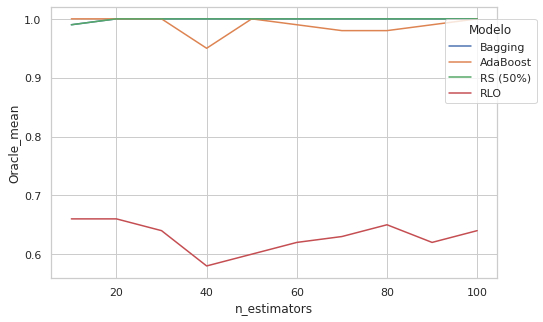

Dataset :  2
/content/result_2.png


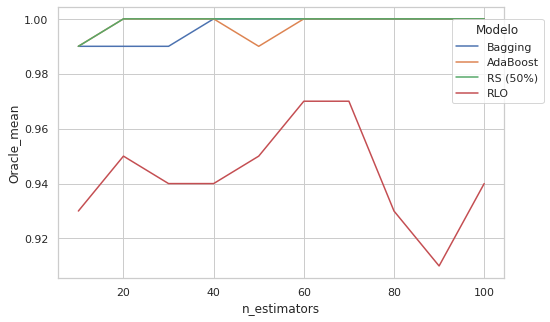

Dataset :  3
/content/result_3.png


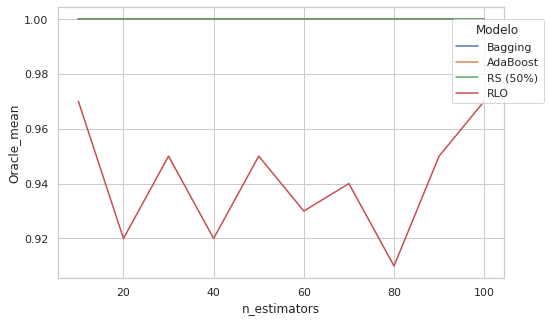

Dataset :  4
/content/result_4.png


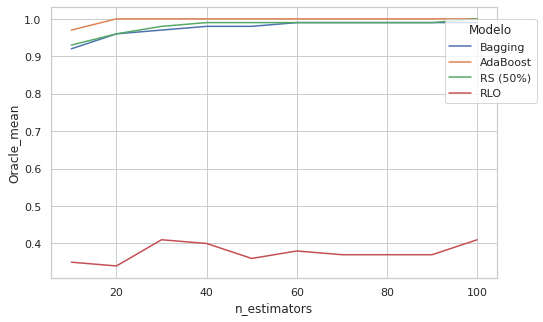

Dataset :  5
/content/result_5.png


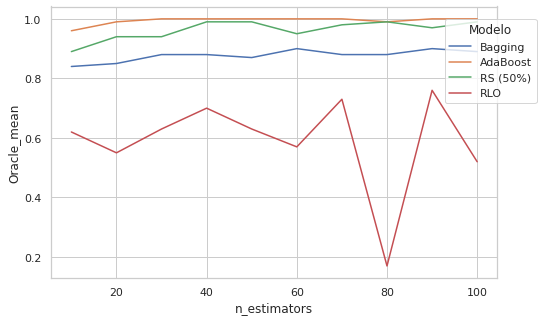

In [66]:
import seaborn as sns

#df_result = pd.DataFrame(columns = ['Modelo', 'Dataset', 'n_estimators', 'Score_mean','Score_std', 'Oracle_mean', 'Oracle_std'])
df_1  = pd.read_csv("/content/bagging_result.csv")
df_2 = pd.read_csv("/content/adaboost_result.csv")
df_3 = pd.read_csv("/content/rs_result.csv")
df_4 = pd.read_csv("/content/rlo_result.csv")

df_result = pd.concat([df_1, df_2,df_3,df_4])

datasets = [1,2,3,4,5]
scores_mean = []
scores_std = []
sns.set_theme(style="whitegrid")

for idx, val in enumerate(datasets):
    print("Dataset : ", val)
    df_data = df_result.loc[(df_result['Dataset'] == val)]
    mean = np.array(df_data.Oracle_mean)
    std = np.array(df_data.Oracle_std)
    # for i in range(len(df_data)):
    #   print(str(mean[i]) + "(" + str(std[i]) + ")")
    fig = plt.figure(figsize=(8,5))      
    ax = sns.lineplot(x="n_estimators", y="Oracle_mean",ci="Oracle_std", hue="Modelo", data=df_data)
    ax.xmin = 10 
    ax.legend(loc='center right',bbox_to_anchor=(1.1, 0.8), ncol=1, title="Modelo")
    file_name = '/content/result_' + str(val) +'.png'
    
    print(file_name)
    fig.savefig(file_name)
    plt.show()


